In [ ]:

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [2]:


import numpy as np
from matplotlib import pyplot as plt
from keras.models import Model


In [3]:


BATCH_SIZE = 80
IMAGE_SIZE = 256

CHANNELS=3  
EPOCHS=100


In [4]:


dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
    
)


Found 6237 files belonging to 29 classes.


In [5]:
class_names = dataset.class_names

class_names

['APPLE HEALTHY LEAVES',
 'APPLE LEAF BLOTCH',
 'APPLE ROT LEAVES',
 'APPLE SCAB LEAVES',
 'Citrus  Canker',
 'Citrus  Greening',
 'Citrus  Healthy',
 'Citrus  Melanose',
 'Citrus Black spot',
 'Citrus Leaf Disease Image',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Rice Bacterial leaf blight',
 'Rice Brown spot',
 'Rice Leaf smut',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy',
 'bean angular_leaf_spot',
 'bean healthy',
 'bean_rust']

In [6]:


for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())  #batch size 32 256 image size 
    
    

(80, 256, 256, 3)
[19 11 12 11 18 11 11 10 25  3  1  3 10 10 19 10 11  4 22 22 19  3  1 12
  5 25 18 25 11  0 17  8 11 20 10  5  8  0 17 11 10 11 24 24 10 10 22 10
 23  5 17 10 21 10 10 18 18 19 10  8  4 11 10 18 10 10 17 25 22 23 11 24
 11 10  8 21 11 17 10  4]


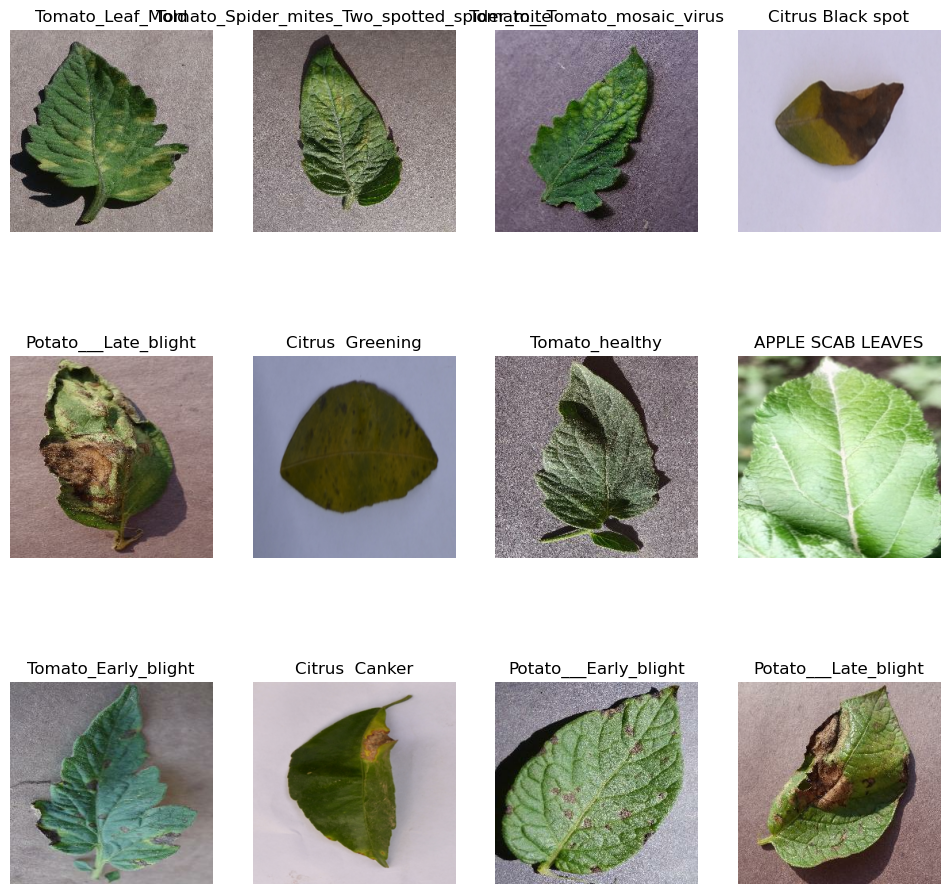

In [7]:


plt.figure(figsize=(12, 12))
for image_batch, labels_batch in dataset.take(1):  
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1) #plot
        plt.imshow(image_batch[i].numpy().astype("uint8"))  #random
        plt.title(class_names[labels_batch[i]]) 
        plt.axis("off")
        
        

# SPLITTING

80% ==>training 20% ==>10% for testing other 10% for validating

In [8]:
len(dataset)    #total images/batch size


78

In [9]:
train_size = 0.8                #580*.8  for training


In [10]:
len(dataset)*train_size


62.400000000000006

In [11]:
train_ds = dataset.take(62)     


In [12]:
len(train_ds)

62

In [13]:
test_ds = dataset.skip(62)


In [14]:
len(test_ds)

16

In [15]:
val_size=0.1


In [16]:
len(dataset)*val_size

7.800000000000001

In [17]:
val_ds = test_ds.take(7)


In [18]:
len(val_ds)

7

In [19]:
test_ds = test_ds.skip(7)


In [20]:
len(test_ds)

9

In [21]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [22]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [23]:
len(train_ds)

62

In [24]:
len(val_ds)

7

In [25]:
len(test_ds)

9

In [26]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


# Getting images into same size

In [27]:
resize_and_rescale = tf.keras.Sequential([
    
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
    
    
])


Changing the image style


In [28]:


data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])




BUILDING THE MODEL


finds the number of layers to be fine-tuned automatically for a target dataset for improved transfer learning

In [29]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [30]:

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 29


In [31]:
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])


In [32]:
model.build(input_shape=input_shape)

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (80, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (80, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (80, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (80, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (80, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (80, 60, 60, 64)         

In [34]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [35]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
)

Epoch 1/100
62/62 [==============================] - 393s 5s/step - loss: 2.9764 - accuracy: 0.1582 - val_loss: 2.9125 - val_accuracy: 0.1554
Epoch 2/100
62/62 [==============================] - 334s 5s/step - loss: 2.6561 - accuracy: 0.2062 - val_loss: 2.7137 - val_accuracy: 0.2464
Epoch 3/100
62/62 [==============================] - 329s 5s/step - loss: 2.1757 - accuracy: 0.3341 - val_loss: 2.5245 - val_accuracy: 0.3107
Epoch 4/100
62/62 [==============================] - 525s 9s/step - loss: 1.8231 - accuracy: 0.4351 - val_loss: 1.8732 - val_accuracy: 0.4589
Epoch 5/100
62/62 [==============================] - 576s 9s/step - loss: 1.5415 - accuracy: 0.5074 - val_loss: 2.2813 - val_accuracy: 0.4446
Epoch 6/100
62/62 [==============================] - 575s 9s/step - loss: 1.2955 - accuracy: 0.5630 - val_loss: 1.4678 - val_accuracy: 0.5750
Epoch 7/100
62/62 [==============================] - 575s 9s/step - loss: 1.1502 - accuracy: 0.6217 - val_loss: 1.4535 - val_accuracy: 0.5964
Epoch 

In [36]:
scores = model.evaluate(test_ds)

9/9 [==============================] - 24s 1s/step - loss: 1.1131 - accuracy: 0.7583


In [37]:
scores

[1.1131383180618286, 0.7583333253860474]

In [38]:
history

In [39]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 62}

In [40]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [41]:
type(history.history['loss'])

list

In [42]:
len(history.history['loss'])

100

In [43]:
history.history['loss'][:5] 

[2.976405143737793,
 2.656061887741089,
 2.175670623779297,
 1.8231335878372192,
 1.541486382484436]

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

print(val_acc)

[0.15535713732242584, 0.24642856419086456, 0.3107142746448517, 0.45892858505249023, 0.4446428716182709, 0.574999988079071, 0.5964285731315613, 0.5964285731315613, 0.5767857432365417, 0.5714285969734192, 0.6482142806053162, 0.6589285731315613, 0.574999988079071, 0.6910714507102966, 0.7553571462631226, 0.6875, 0.7017857432365417, 0.6714285612106323, 0.6392857432365417, 0.6857143044471741, 0.699999988079071, 0.6678571701049805, 0.6857143044471741, 0.7053571343421936, 0.6535714268684387, 0.7017857432365417, 0.7017857432365417, 0.7017857432365417, 0.675000011920929, 0.6964285969734192, 0.7107142806053162, 0.6732142567634583, 0.6589285731315613, 0.699999988079071, 0.7267857193946838, 0.75, 0.7875000238418579, 0.7589285969734192, 0.7446428537368774, 0.737500011920929, 0.7357142567634583, 0.7464285492897034, 0.7678571343421936, 0.6517857313156128, 0.7553571462631226, 0.6571428775787354, 0.7482143044471741, 0.7464285492897034, 0.7571428418159485, 0.7642857432365417, 0.7821428775787354, 0.801785

In [45]:
loss = history.history['loss']
val_loss = history.history['val_loss']

print(val_loss)

[2.912527084350586, 2.713736057281494, 2.524488687515259, 1.8732115030288696, 2.2812511920928955, 1.4677503108978271, 1.4535465240478516, 1.5019623041152954, 1.698115348815918, 1.6668343544006348, 1.3118306398391724, 1.2054601907730103, 1.9493342638015747, 1.095228672027588, 0.7789644598960876, 1.1984091997146606, 1.1412850618362427, 1.1913046836853027, 1.2881730794906616, 1.2465190887451172, 1.042814016342163, 1.4108015298843384, 0.9985139966011047, 1.100374460220337, 1.6976107358932495, 1.0171070098876953, 1.0637658834457397, 1.214632511138916, 1.3333791494369507, 1.1922754049301147, 1.113734245300293, 1.3589485883712769, 1.6649926900863647, 1.0203871726989746, 1.0167267322540283, 0.745908796787262, 0.8100087642669678, 0.8485019207000732, 0.8942797780036926, 0.865425169467926, 1.0267598628997803, 1.0398682355880737, 0.9142562747001648, 1.5820486545562744, 0.9210836291313171, 1.6818673610687256, 0.9426144361495972, 0.9185730218887329, 0.9565274119377136, 0.8604874014854431, 0.83305335

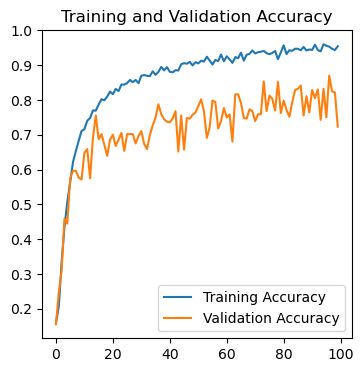

In [58]:
plt.figure(figsize=(4,4 ))

plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.show()

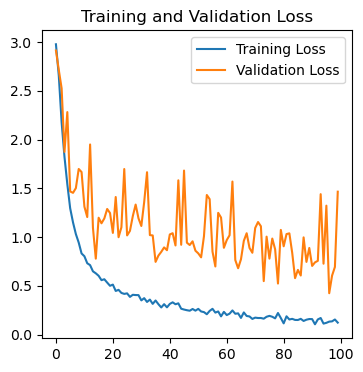

In [47]:
plt.figure(figsize=(4, 4))
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

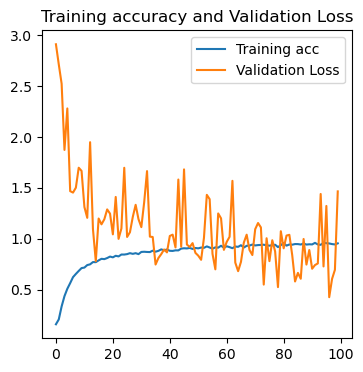

In [59]:
plt.figure(figsize=(4, 4))
plt.plot(range(EPOCHS), acc, label='Training acc')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training accuracy and Validation Loss')

plt.show()

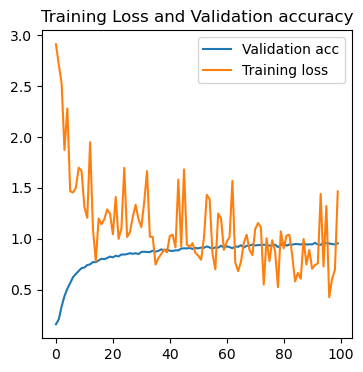

In [60]:
plt.figure(figsize=(4, 4))
plt.plot(range(EPOCHS), acc, label='Validation acc')
plt.plot(range(EPOCHS), val_loss, label='Training loss')
plt.legend(loc='upper right')
plt.title('Training Loss and Validation accuracy')

plt.show()

first image to predict
actual label: Tomato_healthy
3/3 [==============================] - 3s 770ms/step
predicted label: Tomato_healthy


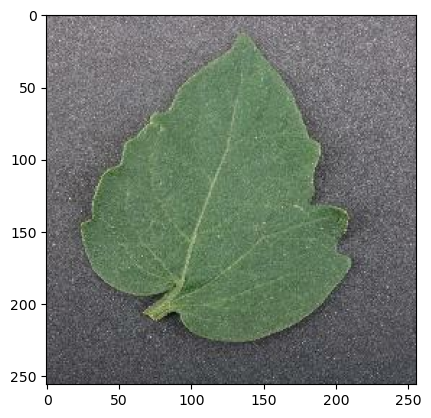

In [63]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])


In [64]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 88ms/step


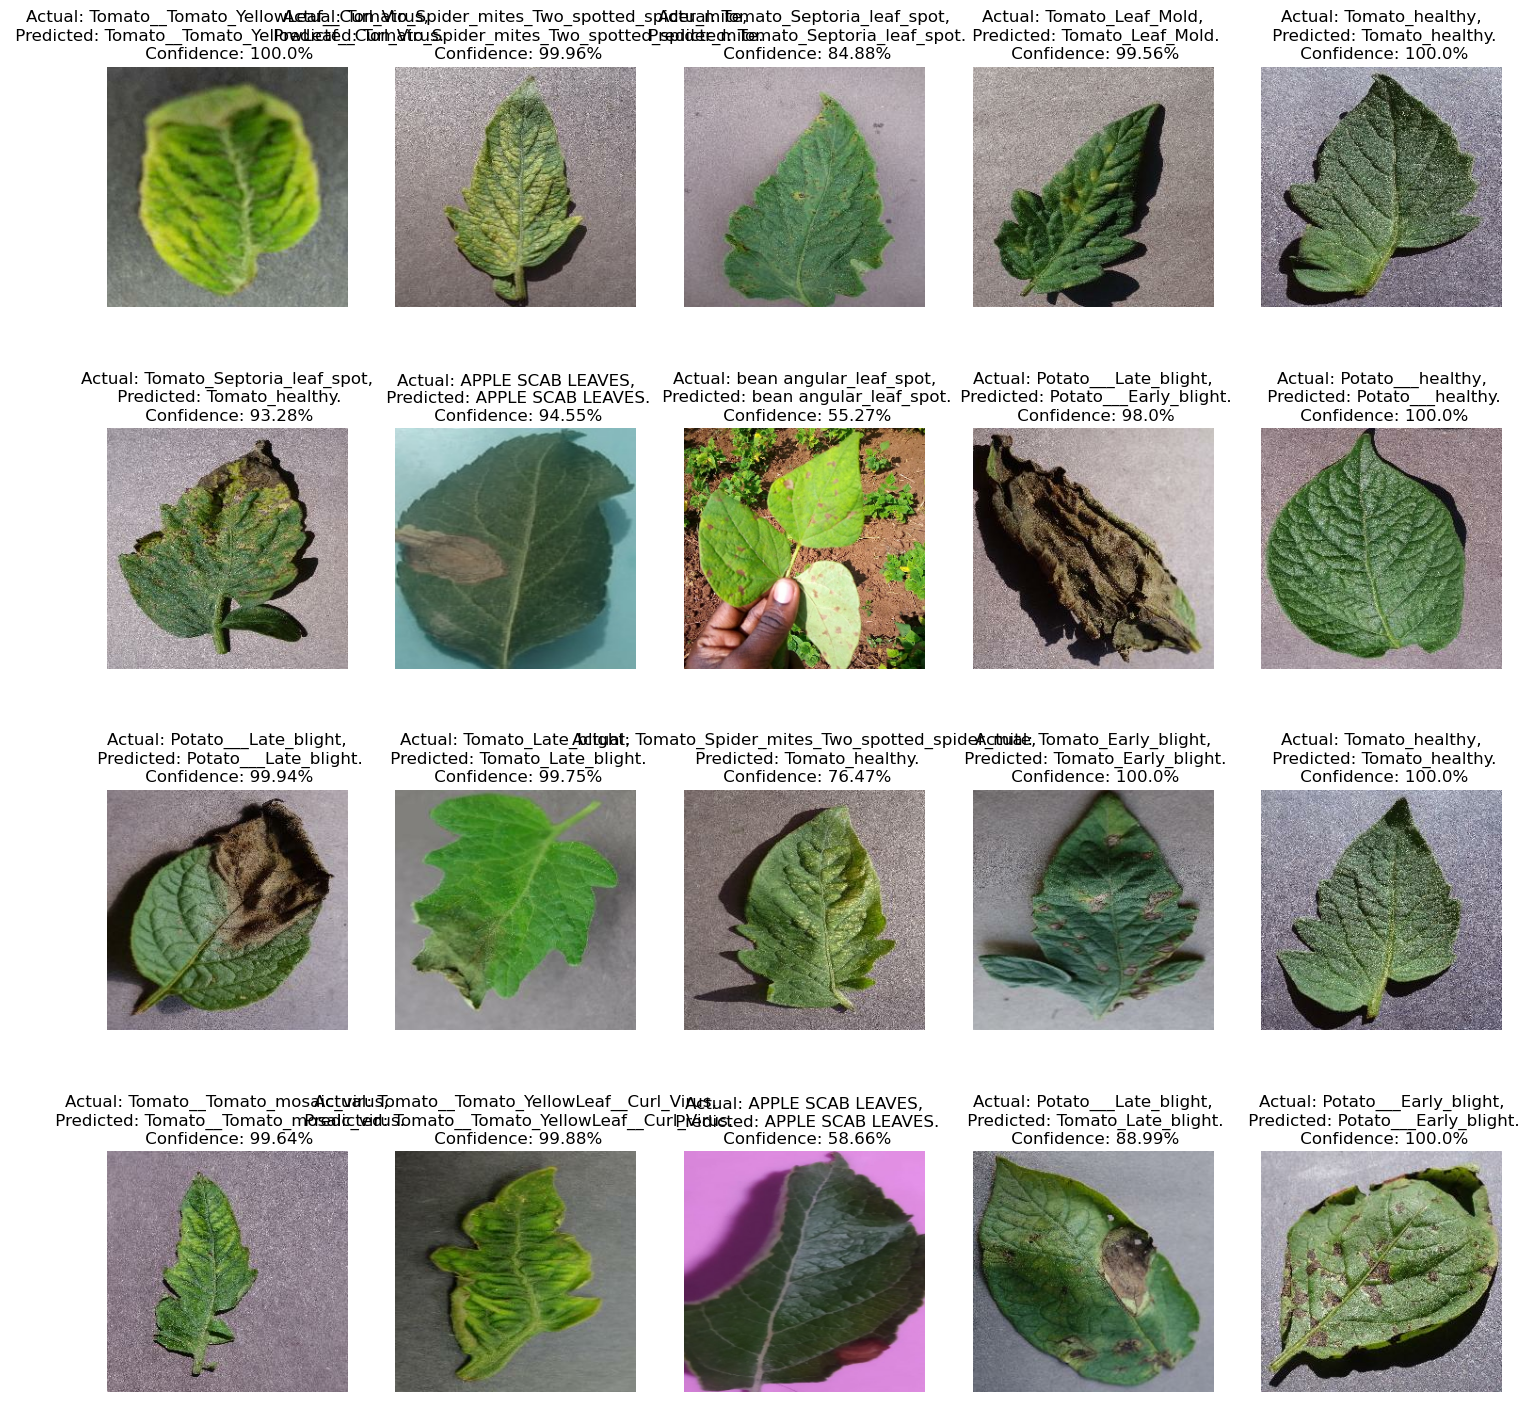

In [69]:
plt.figure(figsize=(18, 18))
for images, labels in test_ds.take(1):
    for i in range(20):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [70]:
import os
os.listdir("../savedmodels")

['1', '2']

In [71]:
import os
model_version=max([int(i) for i in os.listdir("../savedmodels") + [0]])+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/3\assets


INFO:tensorflow:Assets written to: ../saved_models/3\assets


In [72]:
model.save("../potatoes.h5")